# get signal

In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests
from funcs import *

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']



# define constants
tickerpair="ETCUSDT"
interval="5m"
percentile=98
thres_diff=None
#thres_diff = 0.003489
#thres_diff=0.004225 #ETCUSDT 30m 98%
#thres_diff=0.002227 #ETCUSDT 15m 98%
#thres_diff=0.0009295 *0.95 #ETCUSDT 5m 98%
entered=False

# for each tickerpair,interval: find precentile,thres_diff,tp_buy,sl_buy,tp_sell,sl_sell,

In [2]:
%%time
dfmpl = get_data(tickerpair,interval,limit=55000,type="sampledata")
len(dfmpl)

CPU times: total: 1.61 s
Wall time: 1.8 s


55000

In [3]:
%%time
entrys,exits,dfmpl,sc_up,sc_dn,r_high_sm,r_low_sm,r_sm,r_sm_diff,thres_diff = get_entrys_exits(dfmpl,percentile,thres_diff)
entry_signals = get_entry_signals(entrys,dfmpl)
print(entry_signals[:5])
#parse_signals_and_send_msg(entrys,exits,dfmpl,entry_signals,tickerpair,interval)

[(28, 1, Timestamp('2022-10-26 17:10:00')), (56, -1, Timestamp('2022-10-26 19:30:00')), (312, -1, Timestamp('2022-10-27 16:50:00')), (379, 1, Timestamp('2022-10-27 22:25:00')), (494, -1, Timestamp('2022-10-28 08:00:00'))]
CPU times: total: 781 ms
Wall time: 1.32 s


In [4]:
%%time
# post analysis
predict,result,predict_seq,predicted_result = get_predictions(entrys,exits,dfmpl)
lastNsamples = int(len(result)*0.1)
print("total results=",len(result) ,"lastN",lastNsamples) 
profit,trade_dur, df0, df0_signal,hl_pair = get_profit_highlows_of_predictions(entrys,exits,predicted_result,dfmpl)
final_profit,equity = get_all_equity(profit)

total results= 517 lastN 51
CPU times: total: 344 ms
Wall time: 502 ms


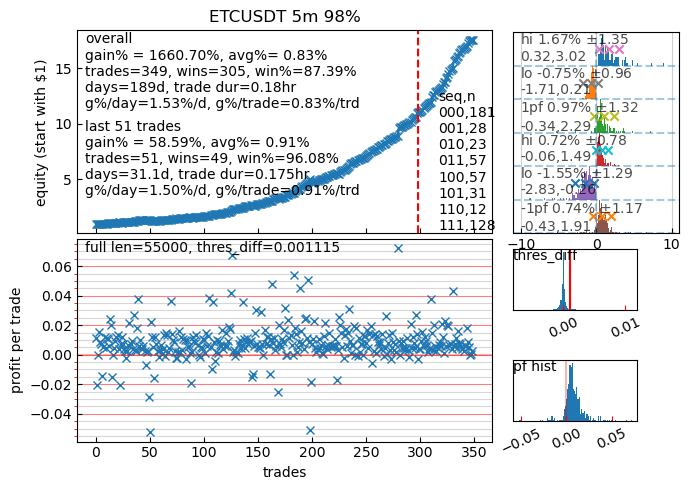

CPU times: total: 2.72 s
Wall time: 3.1 s


In [5]:
%%time
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(8,5),sharex=True,dpi=100)
ax1.plot(equity,"-x")
ax1.set_ylabel("equity (start with $1)")
ax1.set_title(f"{tickerpair} {interval} {percentile}%")
str1,gains__,trading_days = get_stats(dfmpl,sc_up,profit,trade_dur,0)
gs = get_stats(dfmpl,sc_up,profit,trade_dur,lastNsamples)[0]
ax1.text(0.02,0.99, "overall\n"+str1,transform=ax1.transAxes,va="top",ha="left")
ax1.text(0.02,0.56, f"last {lastNsamples} trades\n"+gs,transform=ax1.transAxes,va="top",ha="left")
ax1.text(0.87,0.0, "seq,n\n"+"\n".join([p[0]+","+str(p[1]) for p in predict_seq]),transform=ax1.transAxes,va="bottom",ha="left")
ax1.axvline(len(profit)-lastNsamples,c="r",ls="--")
ax2.plot(profit,"x")
ax2.axhline(0,c="r",alpha=0.3)
ax2.set_ylabel("profit per trade")
ax2.text(0.02,0.99,f"full len={len(dfmpl)}, thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left")
#ax2.text(0.02,0.99,f"thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left")
for ax in (ax1,ax2):
    ax.set_xlabel("trades")
    ax.tick_params("both",direction="in")
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params("y",which='minor',color="r")
ax2.grid(which='minor',axis="y",alpha=0.5)
ax2.grid(which='major',axis="y",color="r",alpha=0.5)
#lt.tight_layout(h_pad=-1.08)

ax3 = ax2.inset_axes((1.05,0.1,0.3,0.3)) 
ax3.text(0,1,"pf hist",transform=ax3.transAxes,va="top",ha="left")
ax3.hist(profit,bins=100)
ax3.axvline(0,c="r",alpha=0.3)
ax3.tick_params("both",direction="in",rotation=25,color="r") 
ax3.set_yticks([])
ax4 = ax2.inset_axes((1.05,0.65,0.3,0.3))
ax4.hist(r_sm_diff,bins=100)
ax4.text(0,1,"thres_diff",transform=ax4.transAxes,va="top",ha="left")
ax4.axvline(thres_diff,c="r")
ax4.tick_params("both",direction="in",rotation=25,color="r")
ax4.set_yticks([])

ax5 = ax1.inset_axes((1.05,0.0,0.4,0.99))
hl_data = get_hl_data(hl_pair)
plot_hl_ax(ax5,hl_pair,hl_data,bres=0.1) 
plt.tight_layout(h_pad=-1.08)
plt.show()
#plt.savefig("fig_temp3.png")

In [6]:
%%time
if False:
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
    ax1.plot(r_high_sm,alpha=0.6)
    ax1.plot(r_low_sm,alpha=0.6)
    ax1.plot(r_sm,alpha=0.6)
    ax1.set_xticks(ax1.get_xticks())
    ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
    n,bins,_ = ax2.hist(r_sm,bins=100)
    thres = np.percentile(r_sm.values[np.where(~np.isnan(r_sm.values))],25)
    ax2.axvline(thres,c="r",label=f"threshold={thres:.4g}")
    ax2.legend()
    ax3.hist(r_sm_diff,bins=100)
    ax3.axvline(thres_diff,c="r",label=f"thres_diff={thres_diff:.4g}")
    ax3.legend()
    plt.show()  
if False:
    upto=20
    concated_df = pd.concat([(i-i.iloc[0].Open)/i.iloc[0].Open for i in df0[:upto]])
    l_ = 0
    scatter_=[]
    scatter_color_up=[]
    scatter_color_dn=[]
    my_vlines = [ ]
    for i,buy in zip( df0[:upto], df0_signal):
        my_vlines.append(l_)
        for ii in range(len(i)):
            l_ +=1
            scatter_.append(np.nan)
            scatter_color_up.append(np.nan)
            scatter_color_dn.append(np.nan)
        scatter_.pop()
        scatter_.append(concated_df.iloc[l_-1].Close)
        if buy>0:
            scatter_color_up.pop()
            scatter_color_up.append(concated_df.iloc[l_-1].Close)
        else:
            scatter_color_dn.pop()
            scatter_color_dn.append(concated_df.iloc[l_-1].Close)
    apds = [
        mpf.make_addplot(scatter_color_up,color='g',type='scatter',marker="x",secondary_y=False),
        mpf.make_addplot(scatter_color_dn,color='r',type='scatter',marker="x",secondary_y=False),
           ]
    fig, axlist =mpf.plot(concated_df,addplot=apds, returnfig=True,ylabel="fraction change")
    for ax in axlist[:]:
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)
    plt.show()
    import matplotlib
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

CPU times: total: 0 ns
Wall time: 0 ns
